In [3]:
from joblib import Parallel, delayed

%run BREPpy.py

conn = Connector()
conn.init_from_script(['--config_fn','./input_files/Parameters.hoc',
                       '--goc_points_fn', './example_simulation/coordinates_input/GoCcoordinates.dat',
                      '--gc_points_fn', './example_simulation/coordinates_input/GCcoordinates.dat'])


p1 = './example_simulation/coordinates_input/'
p2 = './example_simulation/coordinates_input/subsampled/'

go_ori = p1+'GoCcoordinates.dat'
gr_ori = p1+'GCcoordinates.dat'
go_32 = p2+'GoCcoordinates_32.dat'
gr_32 = p2+'GCcoordinates_32.dat'
go_16 = p2+'GoCcoordinates_16.dat'
gr_16 = p2+'GCcoordinates_16.dat'
go_4 = p2+'GoCcoordinates_4.dat'
gr_4 = p2+'GCcoordinates_4.dat' 

# read in parameter file
empty_hoc = dir(neuron.hoc.HocObject()).copy()
config_fn = './input_files/Parameters.hoc'
neuron.h.xopen(config_fn)

# find a single point in a KDTree
def pt_in_tr (kdt, pt, c_rad):
    warnings.simplefilter('ignore')
    ind, = kdt.query_radius(pt, r = c_rad)
    return ind

#a = pt_in_tr(kdt, q_pts[0], 30)


In [29]:
gg = Golgi_pop(h)
gg.load_somata(go_4)
gg.add_dendrites()

gp = Granule_pop(h)
gp.load_somata(gr_4)
gp.add_aa_endpoints_fixed()
gp.add_pf_endpoints()

cc = Connect_2D(gg.qpts, gp.qpts_aa, 30)
kdt, q_pts = cc.search_connections()


print ('none')
%timeit a = [pt_in_tr(kdt,pt,30) for pt in q_pts]

print('njobs = 1')
%timeit a1 = (Parallel(n_jobs=1)(delayed(pt_in_tr)(kdt, pt, 30) for pt in q_pts))

print('njobs = 2')
%timeit a1 = (Parallel(n_jobs=2)(delayed(pt_in_tr)(kdt, pt, 30) for pt in q_pts))

print('njobs = 3')
%timeit a1 = (Parallel(n_jobs=3)(delayed(pt_in_tr)(kdt, pt, 30) for pt in q_pts))

print('njobs = 4')
%timeit a1 = (Parallel(n_jobs=4)(delayed(pt_in_tr)(kdt, pt, 30) for pt in q_pts))

print('njobs = 6')
%timeit a1 = (Parallel(n_jobs=6)(delayed(pt_in_tr)(kdt, pt, 30) for pt in q_pts))

In [7]:
# And now with a loop and a saving file...

n_jobs_a = [-1, 1 , 2, 3, 4, 6]
files = [[go_32, gr_32], [go_16, gr_16], [go_4, gr_4]]
import time
import numpy as np

times = np.zeros((len(files), len(n_jobs_a)))
for fn, [go, gr] in enumerate(files):
                 
    gg = Golgi_pop(h)
    gg.load_somata(go)
    gg.add_dendrites()
    gp = Granule_pop(h)
    gp.load_somata(gr)
    gp.add_aa_endpoints_fixed()
    gp.add_pf_endpoints()
                 
    cc = Connect_2D(gg.qpts, gp.qpts_aa, 30)
    kdt, q_pts = cc.search_connections()
                 
    for njc, nj in enumerate(n_jobs_a):
        start = time.time()
        if nj<0:
            a = [pt_in_tr(kdt,pt,30) for pt in q_pts]
        else:
            a = (Parallel(n_jobs=njc)(delayed(pt_in_tr)(kdt, pt, 30) for pt in q_pts))
        times[fn, njc] = time.time()-start

np.savetxt('times_parallel.txt', times)
            



(13112, 2)
(52778, 2)
(211571, 2)


It seems as if this is not really succesfull, multithreading does increase the computation time. 
This is probably because sklearn KDTree uses Cython (https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/kd_tree.pyx), so a GIL (Global Interpreter Lock) is enabled, which prevents more than one native thread active. 

Thus, multithreading seems not to be a useful option, and we should look into multiprocessing.

http://people.duke.edu/~ccc14/sta-663-2016/19C_IPyParallel.html



https://stackoverflow.com/questions/5128072/how-efficient-is-threading-in-python
-> not very efficient due to GIL, have to use multiprocessing (actually, not a complete answer, however:)

https://softwareengineering.stackexchange.com/questions/186889/why-was-python-written-with-the-gil
-> CPython definitely does, and KDTrees from sklearn do use that.

https://stackoverflow.com/questions/3044580/multiprocessing-vs-threading-python

https://stackoverflow.com/questions/18114285/python-what-are-the-differences-between-the-threading-and-multiprocessing-modul
-> good explanation



9028


In [130]:
%run BREPpy.py


import matplotlib.pyplot as plt
%matplotlib inline
gg.plot_somata(True, 'ro')
gp.plot_somata(False, 'k.', markersize = 0.1)

Failure to initialize connector, there is not one linearized and one regular point set


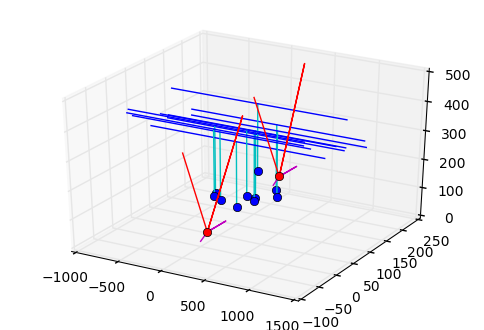

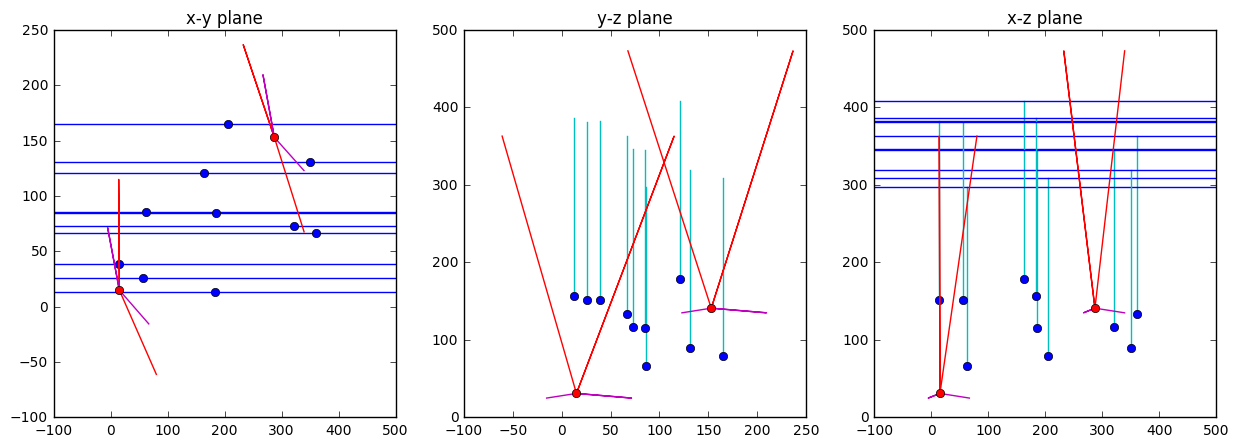

In [162]:
## plot some full cells
gr_pop = gp
go_pop = gg

gr_cells = np.random.randint(0, len(gr_pop.som), 10)
go_cells = np.random.randint(0, len(go_pop.som), 2)


# 3D plot
plt.figure()
ax = plt.gcf().gca(projection='3d')
def plot3d (ax, dat, *args, **kwargs):
    if len(dat.shape) == 1: #if single dot
        dat = np.expand_dims(dat, axis = 0)
    ax.plot(dat[:,0], dat[:,1], dat[:,2], *args, **kwargs)

for c in gr_cells:
    plot3d(ax, gr_pop.aa_dots[c], 'c')
    plot3d(ax, gr_pop.pf_dots[c], 'b')
    plot3d(ax, gr_pop.som[c], 'bo')

for c in go_cells:
    plot3d(ax, go_pop.a_dend[c], 'r')
    plot3d(ax, go_pop.b_dend[c], 'm')
    plot3d(ax, np.expand_dims(go_pop.som[c], axis = 0), 'ro')
    
    
#2D projections
plt.figure(figsize=(15,5))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    
    plt.subplot(1,3,i+1)
    
    for c in gr_cells:
        plt.plot(gr_pop.aa_dots[c,:,j], gr_pop.aa_dots[c,:,k], 'c')
        plt.plot(gr_pop.pf_dots[c,:,j], gr_pop.pf_dots[c,:,k], 'b')
        plt.plot(gr_pop.som[c,j], gr_pop.som[c,k], 'bo')

    for c in go_cells:
        plt.plot(go_pop.a_dend[c,:,j], go_pop.a_dend[c,:,k], 'r')
        plt.plot(go_pop.b_dend[c,:,j], go_pop.b_dend[c,:,k], 'm')
        plt.plot(go_pop.som[c,j], go_pop.som[c,k], 'ro')
    
    if True:
        if i in [0,2]: plt.xlim([-100, 500])
    plt.title (tit)

In [14]:
qpt = Query_points(gg.som)

qpt.npts

1995

In [102]:
from neuron import hoc, h

%run BREPpy.py


empty_hoc = dir(neuron.hoc.HocObject()).copy()
config_fn = './input_files/Parameters.hoc'
#load our own hoc object from the parameter file, get the disjunct list of parameters (probably useless...)
neuron.h.xopen(config_fn)
gp = Granule_pop(h)
gp.load_somata('./example_simulation/coordinates_input/GCcoordinates.dat')


plt.figure()
ax = plt.gcf().gca(projection='3d')
ax.plot(gp.som[:,0], gp.som[:,1], gp.som[:,2], *args)

AttributeError: 'Granule_pop' object has no attribute 'add_aa_random'

In [54]:
from neuron import hoc, h

%run BREPpy.py
gp = Granule_pop('./example_simulation/coordinates_input/GCcoordinates.dat', h)
gp.add_aa_endpoints_random()



AttributeError: 'Granule_pop' object has no attribute 'add_aa_random'

In [ ]:
    def read_in_config2 (self):
       '''checks if a config file has been specified, and if so, updates the args.
        If overwrite_config is set True, command line arguments that specify a parameter that also exists
        in the config file will have priority.'''
        if self.args.config_fn == '':
            warnings.warn('Cannot find config file!')
        else:  #read in config file using neurons h object
            self.p_verb('Reading config file')
            empty_hoc = dir(hoc.HocObject()).copy()
            neuron.h.xopen(self.args.config_fn)
            full_hoc = dir(neuron.h) 
        self.


In [50]:
%run BREPpy.py

200.0


# Visualization of Golgi cells

For both the apical and the basal dendrites, a parameter GoC_*d_nseg is defined by `int((GoC_ApicalDendL/(GoC_d_lambda*GoC_d_lambda_f)+0.9)/2)*2 + 1 ` (analogous for BasolateralDendL)
Plugging in the values for the other parameters specified, I get that only if the length parameter GoC_**DendL is >= 488.6 (which seems an unlikely case), this parameter is not 1. (Values in the current config file are 166 for apical, 60 for basolateral)
I would like to understand what this parameter does and what it is used for (something cable equationish?)


# Visualization of Parallel fiber

# Visualization of Somata

# Single connection visualization

# Connection density visualization

In [100]:
l = 166
fr = l/(0.1*1000*np.sqrt (3/(4*np.pi)))
print (fr)
nsegp = fr+0.9
nseg = int(nsegp/2)*2+1
print (nsegp)
print (nseg)


3.39744467038
4.29744467038
5


In [97]:
int (0.9)

0

In [101]:
b = 'ga'
print (type(b) == str)

True


In [ ]:
import threading
from queue import Queue
import time




In [ ]:
%connect_info #-> gives the number and the address of the kernel you use
%qtconsole #-> opens the console with iqdb
%debug #-> starts a iqdb pocess inline
#-> here, if you print debug, you will jump to the last error. Leave with q

# pdb.set_trace() -> 